In [9]:
# Import necessary libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cftime  # Make sure this library is installed=
import scipy
import sys

In [10]:
# Replace with the correct paths to your NetCDF files
file_path_control = '/Users/braghiere/Documents/Working_papers/FUN_cost_parameters/npp_totc_2015_2104_control.nc'
file_path_kparams = '/Users/braghiere/Documents/Working_papers/FUN_cost_parameters/npp_totc_2015_2104.nc'

In [11]:
# Open the NetCDF files using xarray
control_dataset = xr.open_dataset(file_path_control)
kparams_dataset = xr.open_dataset(file_path_kparams)

# Extract the NPP and TOTC variables
# Replace 'NPP' and 'TOTC' with the actual variable names in your files if they are different
npp_control = control_dataset['NPP']
totc_control = control_dataset['TOTCOLC']
years = kparams_dataset['time']

# Convert cftime objects to numeric years (assuming 'time' is the coordinate name)

npp_kparams = kparams_dataset['NPP']
totc_kparams = kparams_dataset['TOTCOLC']
numeric_years = [date.year for date in npp_kparams['time'].values]

# Close the NetCDF files after extracting the necessary data
control_dataset.close()
kparams_dataset.close()

In [12]:
# Calculate the weights as the cosine of the latitude (in radians)
# Check if the latitude is in degrees and convert it if necessary
lat = np.radians(kparams_dataset['lat'])  # Replace 'lat' with the actual name of your latitude coordinate
weights = np.cos(lat)

# We need to broadcast the weights to match the shape of the NPP array
weights = weights / weights.mean()  # Normalize the weights
shape = npp_kparams.sizes
weights_broadcasted = weights.broadcast_like(npp_kparams.isel(time=0))

# Calculate the weighted average over the latitude and longitude dimensions
# This assumes that the sum of the weights over the latitude and longitude is 1
global_avg_npp = (npp_kparams * weights_broadcasted).mean(dim=('lat', 'lon'))
global_avg_npp_control = (npp_control * weights_broadcasted).mean(dim=('lat', 'lon'))

# Calculate the weighted average over the latitude and longitude dimensions
# This assumes that the sum of the weights over the latitude and longitude is 1
global_avg_totc = (totc_kparams * weights_broadcasted).mean(dim=('lat', 'lon'))
global_avg_totc_control = (totc_control * weights_broadcasted).mean(dim=('lat', 'lon'))
# The result is a 1D array of the global average NPP per year


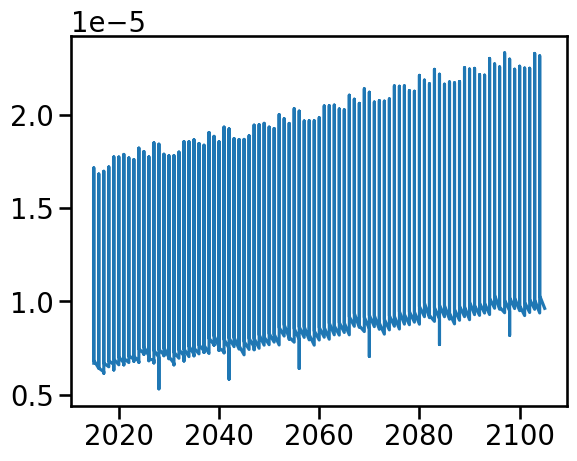

In [13]:
# Now you can plot using the numeric years
plt.plot(numeric_years, global_avg_npp)
plt.show()

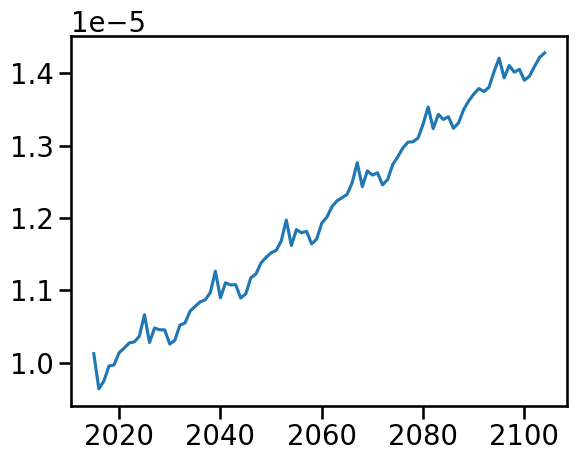

In [14]:
# Convert global_avg_npp to a NumPy array
global_avg_npp_np = global_avg_npp.values
global_avg_npp_np_control = global_avg_npp_control.values

npp_yearly = global_avg_npp.resample(time='Y').mean(dim='time')

# Get the numeric years
numeric_years = npp_yearly.time.dt.year

# Plot using the numeric years
#plt.plot(numeric_years, global_avg_npp_np)
plt.plot(numeric_years[:-1], npp_yearly[:-1])

plt.show()

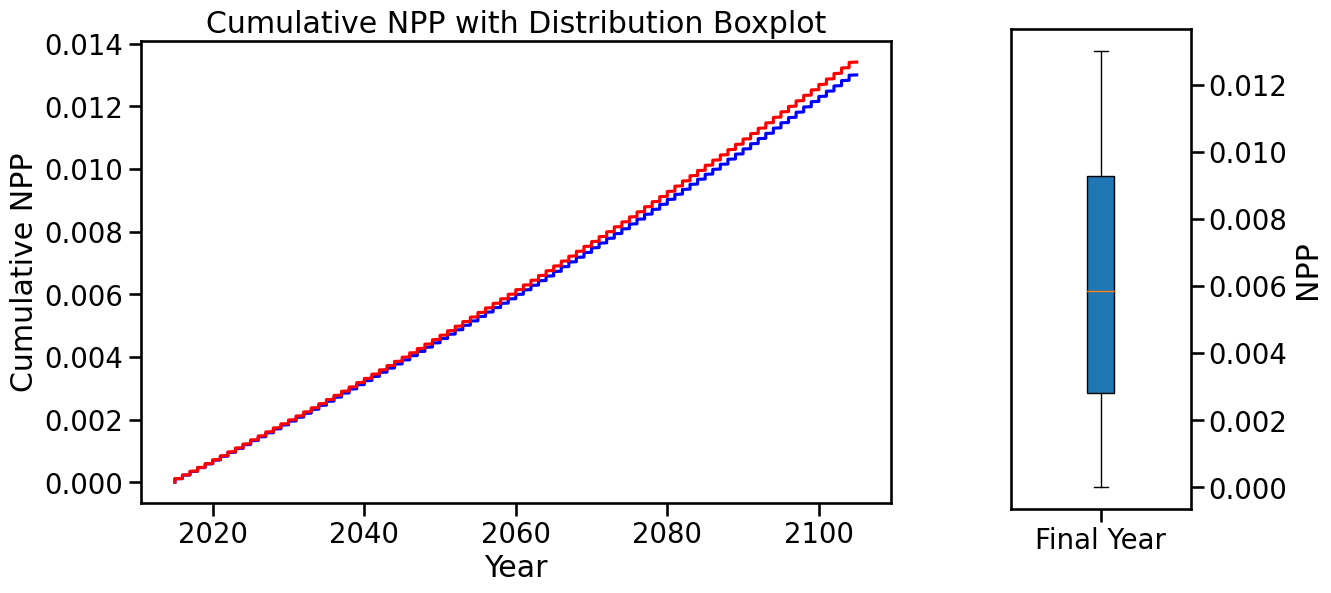

In [15]:
cumulative_npp = np.cumsum(global_avg_npp_np)
cumulative_npp_control = np.cumsum(global_avg_npp_np_control)

# Create the main figure and primary axis for the cumulative NPP plot
fig, ax_main = plt.subplots(figsize=(12, 6))

# Convert cftime objects to numeric years (assuming 'time' is the coordinate name)
numeric_years = [date.year for date in npp_kparams['time'].values]

# Plot the cumulative NPP on the primary axis
ax_main.plot(numeric_years, cumulative_npp, label='Cumulative NPP', color='blue')
ax_main.plot(numeric_years, cumulative_npp_control, label='Cumulative NPP', color='red')
ax_main.set_xlabel('Year')
ax_main.set_ylabel('Cumulative NPP')
ax_main.set_title('Cumulative NPP with Distribution Boxplot')

# Create an inset axis for the box plot on the right-hand side
# The position and size of the inset can be adjusted as needed
box_ax = fig.add_axes([0.85, 0.1, 0.15, 0.8])  # [left, bottom, width, height] in figure coordinates

# Create a box plot for the last value in the cumulative NPP data
# In practice, this could be a subset or distribution of your data
box_ax.boxplot(cumulative_npp, vert=True, patch_artist=True)
box_ax.set_xticklabels(['Final Year'])
box_ax.set_ylabel('NPP')
box_ax.yaxis.tick_right()  # Move the y-axis to the right side
box_ax.yaxis.set_label_position("right")

# Ensure the main plot doesn't overlap with the boxplot
plt.subplots_adjust(right=0.75)

# Show the combined plot
plt.show()


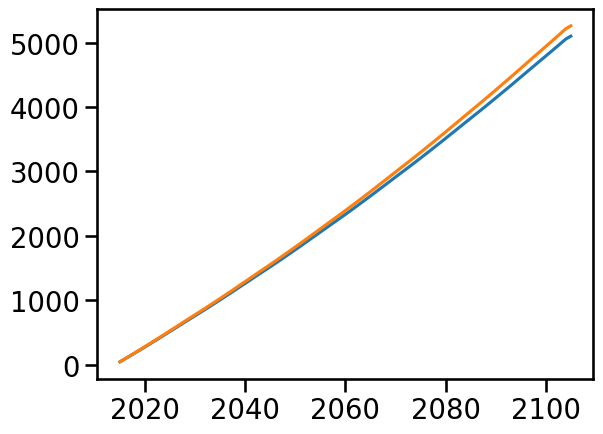

In [17]:
# Conversion factors
seconds_per_year = 365 * 24 * 60 * 60  # Number of seconds in a year
grams_per_pg = 1e15  # Number of grams in a petagram
area_of_earth_m2 = 510.1e12*0.29  # Total surface area of Earth in m2

# Convert global_avg_npp to a NumPy array
global_avg_npp_np = global_avg_npp.values
global_avg_npp_np_control = global_avg_npp_control.values

npp_yearly = global_avg_npp.resample(time='Y').mean(dim='time')* seconds_per_year / grams_per_pg * area_of_earth_m2
npp_yearly_control = global_avg_npp_control.resample(time='Y').mean(dim='time')* seconds_per_year / grams_per_pg * area_of_earth_m2

# Get the numeric years
numeric_years = npp_yearly.time.dt.year

# Plot using the numeric years
#plt.plot(numeric_years, global_avg_npp_np)
plt.plot(numeric_years, np.cumsum(npp_yearly))
plt.plot(numeric_years, np.cumsum(npp_yearly_control))

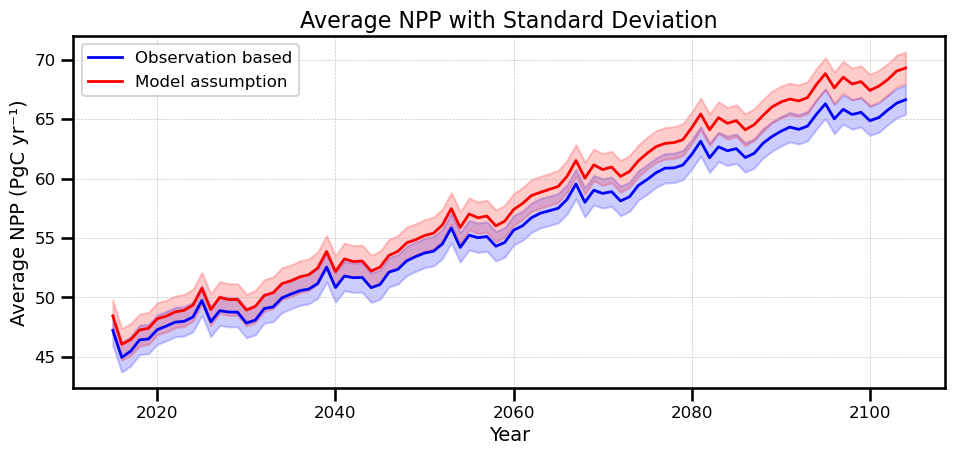

In [18]:
# Conversion factors
seconds_per_year = 365 * 24 * 60 * 60  # Number of seconds in a year
grams_per_pg = 1e15  # Number of grams in a petagram
area_of_earth_m2 = 510.1e12*0.29  # Total surface area of Earth in m2

# Convert units from gCm-2s-1 to PgCyr-1
npp_converted = global_avg_npp_np * seconds_per_year / grams_per_pg * area_of_earth_m2
npp_converted_control = global_avg_npp_np_control * seconds_per_year / grams_per_pg * area_of_earth_m2


# Calculate average and standard deviation of NPP in PgCyr-1
average_npp = np.mean(npp_converted)
std_npp = np.std(npp_converted)
std_npp_control = np.std(npp_converted_control)

# Calculate 95% confidence interval

z = scipy.stats.norm.ppf(0.975)  # Z-score for 95% confidence
ci_npp = z * np.std(npp_converted) / np.sqrt(len(npp_converted))
ci_npp_control = z * np.std(npp_converted_control) / np.sqrt(len(npp_converted_control))

# Define the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the average NPP with standard deviation as a shaded area
#ax.plot(numeric_years, npp_converted, label='Average NPP', color='blue', linewidth=2)
#ax.fill_between(numeric_years, npp_converted - std_npp, npp_converted + std_npp, color='blue', alpha=0.2)
ax.plot(numeric_years[:-1], npp_yearly[:-1], label='Observation based', color='blue', linewidth=2)
ax.fill_between(numeric_years[:-1], npp_yearly[:-1] - ci_npp, npp_yearly[:-1] + ci_npp, color='blue', alpha=0.2)
ax.plot(numeric_years[:-1], npp_yearly_control[:-1], label='Model assumption', color='red', linewidth=2)
ax.fill_between(numeric_years[:-1], npp_yearly_control[:-1] - ci_npp_control, npp_yearly_control[:-1] + ci_npp_control, color='red', alpha=0.2)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Average NPP (PgC yr⁻¹)', fontsize=14)
ax.set_title('Average NPP with Standard Deviation', fontsize=16)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend
ax.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()



/var/folders/w_/lxh510q93ln6zrtpz0_ktmq80000gn/T/ipykernel_5574/3235293155.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['Model', 'Observed'], rotation=45,fontsize=18)
/var/folders/w_/lxh510q93ln6zrtpz0_ktmq80000gn/T/ipykernel_5574/3235293155.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


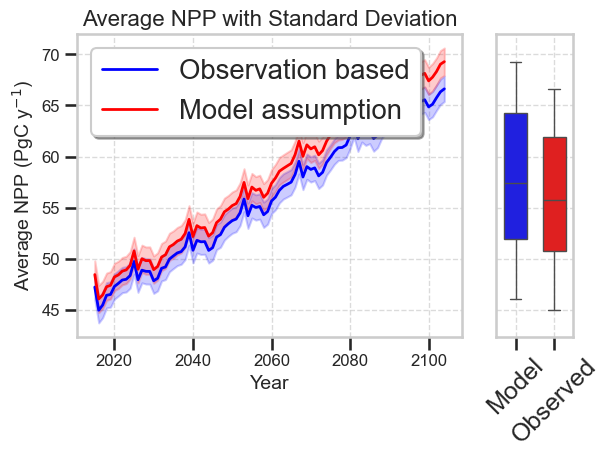

In [30]:
from scipy.io import netcdf
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")
from netCDF4 import Dataset, date2index
import matplotlib.pyplot as plt
import sys
import matplotlib as mpl
import numpy.ma as ma
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.gridspec import GridSpec
import pandas as pd


# Improved style settings for a professional look
plt.style.use('seaborn-whitegrid')
sns.set_context("talk", font_scale=1.2)

# Create a figure and a set of subplots
fig, ax = plt.subplots()
gs = GridSpec(1, 2, width_ratios=[5, 1], wspace=0.15)  # Adjusted spacing between plots

# Create the scatter and error bar plot
ax1 = plt.subplot(gs[0])


ax1.plot(numeric_years[:-1], npp_yearly[:-1], label='Observation based', color='blue', linewidth=2)
ax1.fill_between(numeric_years[:-1], npp_yearly[:-1] - ci_npp, npp_yearly[:-1] + ci_npp, color='blue', alpha=0.2)
ax1.plot(numeric_years[:-1], npp_yearly_control[:-1], label='Model assumption', color='red', linewidth=2)
ax1.fill_between(numeric_years[:-1], npp_yearly_control[:-1] - ci_npp_control, npp_yearly_control[:-1] + ci_npp_control, color='red', alpha=0.2)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel(r'Average NPP (PgC y$^{-1}$)', fontsize=14)
ax1.set_title('Average NPP with Standard Deviation', fontsize=16)
ax1.tick_params(axis='both', labelsize=12)
#ax1.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend
ax1.legend(fontsize=12)


# Add a legend
ax1.legend(loc='best', frameon=True, shadow=True)

# Add grid
ax1.grid(True, linestyle='--', linewidth=1, alpha=0.7)

# Combine data into a DataFrame
data1 = pd.DataFrame({'Model': npp_yearly_control[:-1],'Observed': npp_yearly[:-1]})


# Create the box plot in the adjacent subplot
ax2 = plt.subplot(gs[1], sharey=ax1)  # Share y-axis with ax1
sns.boxplot(data=data1, ax=ax2, width=0.6, palette=['blue', 'red'])
ax2.set_xticklabels(['Model', 'Observed'], rotation=45,fontsize=18)
#ax2.set_title('Comparison of CLM and Observed', fontsize=14)
ax2.set_ylabel('')  # Remove y-axis label to avoid redundancy


# Hide y-axis ticks and labels for ax2
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)
# Add grid
ax2.grid(True, linestyle='--', linewidth=1, alpha=0.7)

# Adjust the subplot so the text doesn't run off the image
plt.subplots_adjust(bottom=0.25)

plt.tight_layout()

#plt.savefig("ekn_pft_v2.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
